https://www.cloudskillsboost.google/course_sessions/5605954/labs/405126

#Przegląd

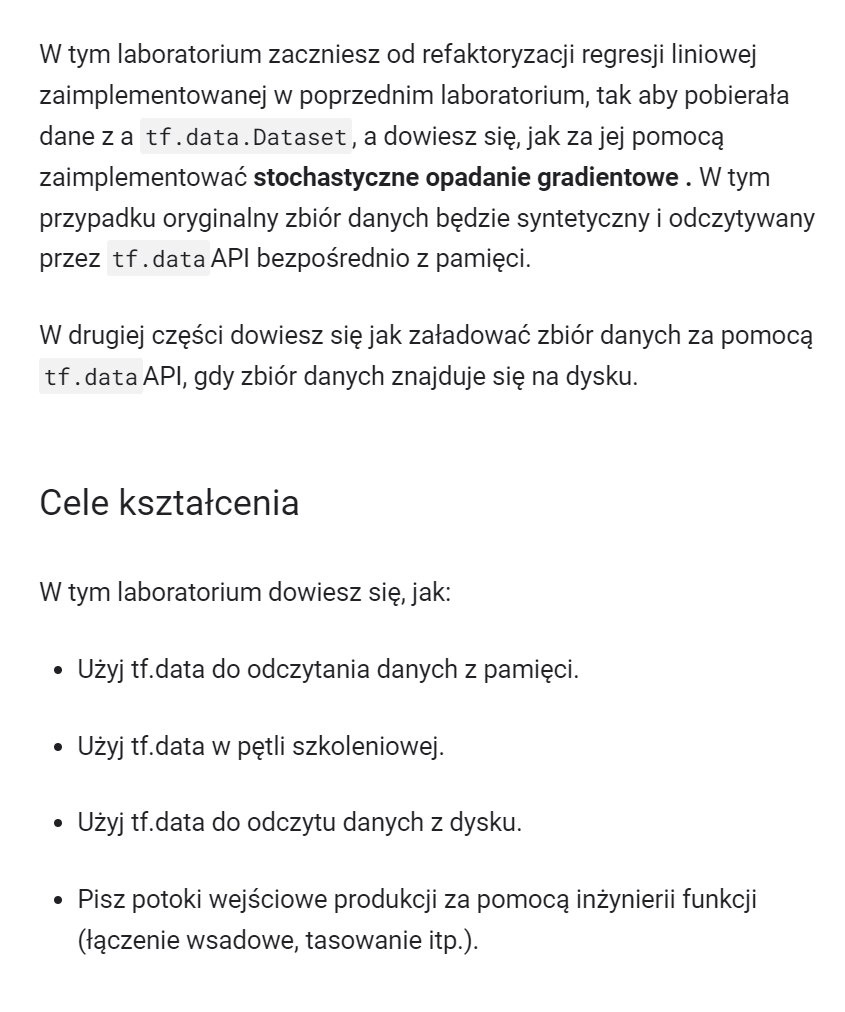

#Zadanie 1. Uruchom notesy Vertex AI

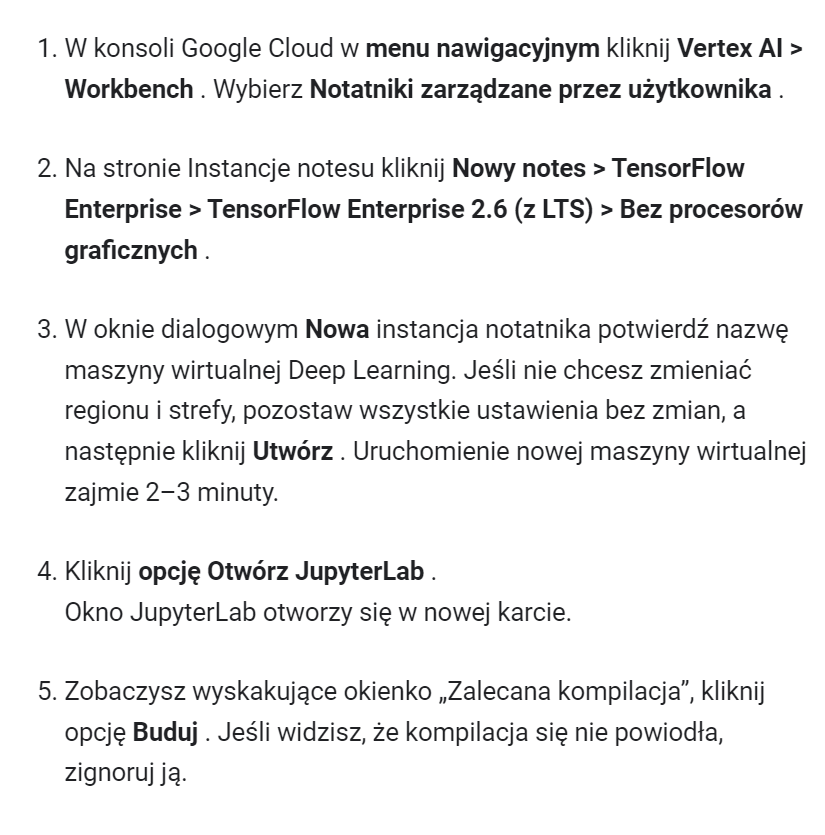

#Zadanie 2. Sklonuj repozytorium kursów w instancji Vertex AI Notebooks

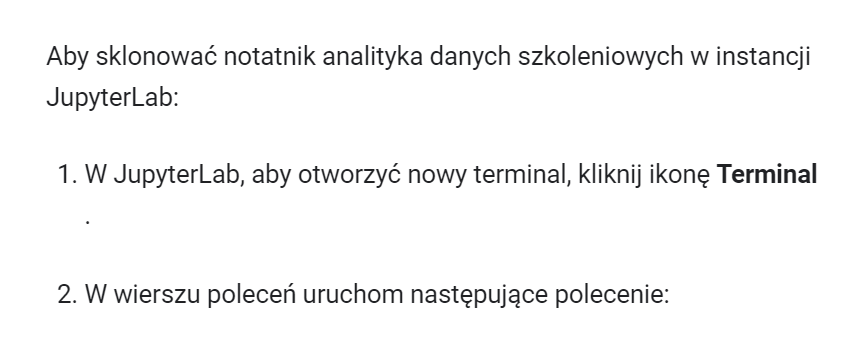

In [ ]:
git clone https://github.com/GoogleCloudPlatform/training-data-analyst

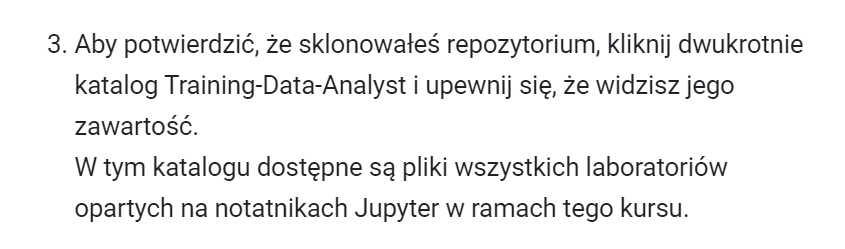

#Zadanie 3. Manipuluj danymi za pomocą tf.data

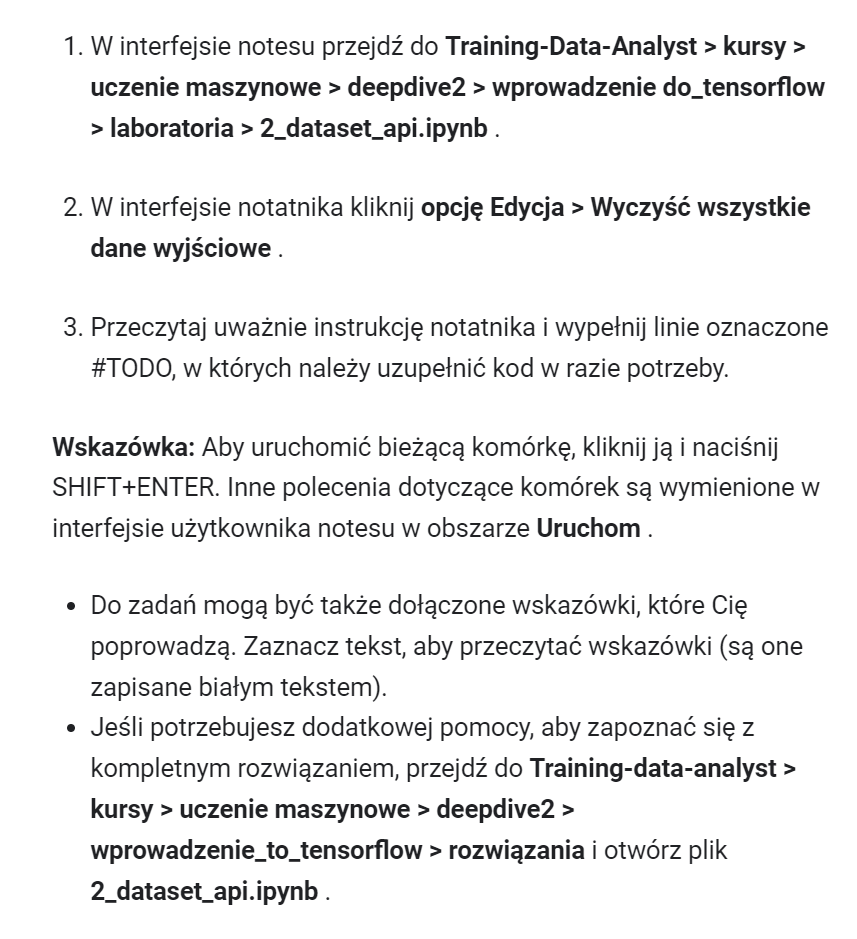

#tf.data

`tf.data` to zestaw narzędzi i API `TensorFlow` do ujednolicania i przygotowania danych do treningu i testowania modeli uczenia maszynowego. Umożliwia przetwarzanie danych w sposób streamingowy, co oszczędza pamięć i czas.

Przykłady zastosowania `tf.data`:

* Przygotowanie danych do treningu modelu rozpoznawania obrazów.
* Przygotowanie danych do treningu modelu tłumaczenia języków.
* Przygotowanie danych do treningu modelu klasyfikacji tekstów.

Podsumowanie:

`tf.data` to potężny zestaw narzędzi, który może znacznie ułatwić i przyspieszyć proces treningu i testowania modeli uczenia maszynowego.

**Cele kształcenia**
1. Dowiedz się, jak używać tf.data do odczytu danych z pamięci
1. Dowiedz się, jak używać tf.data w pętli treningowej
1. Dowiedz się, jak używać tf.data do odczytu danych z dysku
1. Dowiedz się, jak pisać potoki wejściowe produkcji z wykorzystaniem inżynierii funkcji (łączenie wsadowe, tasowanie itp.)


W tym notatniku zaczniemy od refaktoryzacji regresji liniowej, którą zaimplementowaliśmy w poprzednim laboratorium, tak aby pobierała ona dane z `tf.data.Dataset`, i dowiemy się, jak za jej pomocą zaimplementować **stochastyczne opadanie gradientowe**. W tym przypadku oryginalny zbiór danych będzie syntetyczny i odczytany przez API `tf.data` bezpośrednio z pamięci.

W drugiej części dowiemy się, jak załadować zbiór danych za pomocą API `tf.data`, gdy zbiór danych znajduje się na dysku.

Każdy cel edukacyjny będzie odpowiadał __#TODO__ w tym notatniku laboratorium studenckiego — spróbuj najpierw wypełnić ten notatnik, a następnie przejrzyj [notatnik z rozwiązaniami](../solutions/2_dataset_api.ipynb).

In [ ]:
# Moduł json służy głównie do konwersji powyższego słownika Pythona na ciąg JSON, który można zapisać w pliku
import json
# Moduł matematyczny w Pythonie udostępnia pewne funkcje matematyczne
import math
# Moduł OS w Pythonie zapewnia funkcje interakcji z systemem operacyjnym
import os
# Moduł pprint umożliwia „ładne wydrukowanie” dowolnych struktur danych Pythona w formie, która może zostać wykorzystana jako dane wejściowe dla interpretera
from pprint import pprint

# Tutaj zaimportujemy biblioteki przetwarzania danych, takie jak numpy i tensorflow
import numpy as np
import tensorflow as tf
# Tutaj pokażemy aktualnie zainstalowaną wersję TensorFlow
print(tf.version.VERSION)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2.13.0


## Loading data from memory

### Creating the dataset

Rozważmy syntetyczny zbiór danych z poprzedniej sekcji:

In [ ]:
N_POINTS = 10
X = tf.constant(range(N_POINTS), dtype=tf.float32)
Y = 2 * X + 10

In [ ]:
pprint(X)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)>


In [ ]:
pprint(Y)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([10., 12., 14., 16., 18., 20., 22., 24., 26., 28.], dtype=float32)>


Zaczynamy od zaimplementowania funkcji, która przyjmuje dane wejściowe


- nasze wektory $X$ i $Y$ danych syntetycznych wygenerowanych przez funkcję liniową $y= 2x + 10$
- liczba przejść przez zbiór danych, na którym chcemy trenować („epochs”)
- wielkość partii zbioru danych (`batch_size`)

i zwraca `tf.data.Dataset`:

**Uwaga:** Należy pamiętać, że ostatnia partia może nie zawierać dokładnie określonej liczby elementów, ponieważ zbiór danych został wyczerpany.

Jeśli chcesz, aby partie zawierały dokładnie tę samą liczbę elementów w partii, będziemy musieli odrzucić ostatnią partię (batch)

ustawienie:

```python
dataset = dataset.batch(batch_size, drop_remainder=True)
```

We will do that here.

**Zadanie laboratoryjne nr 1:** Uzupełnij poniższy kod, aby
1. Utwórz instancję zbioru danych `tf.data` przy użyciu [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices).
2. Skonfiguruj zbiór danych
   * powtórz „epochs”,
   * utwórz partię o rozmiarze `batch_size`, ignorując dodatkowe elementy, gdy partia nie dzieli równomiernie liczby elementów wejściowych.

In [ ]:
# Let's define create_dataset() procedure
# TODO 1
def create_dataset(X, Y, epochs, batch_size):
# Using the tf.data.Dataset.from_tensor_slices() method we are able to get the slices of list or array
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder=True)
    return dataset

Przetestujmy naszą funkcję, wykonując dwukrotnie iterację naszego zbioru danych w partiach po 3 punkty danych:

In [ ]:
BATCH_SIZE = 3
EPOCH = 2

dataset = create_dataset(X, Y, epochs=EPOCH, batch_size=BATCH_SIZE)

for i, (x, y) in enumerate(dataset):
    print("x:", x.numpy(), "y:", y.numpy())
    assert len(x) == BATCH_SIZE
    assert len(y) == BATCH_SIZE

x: [0. 1. 2.] y: [10. 12. 14.]
x: [3. 4. 5.] y: [16. 18. 20.]
x: [6. 7. 8.] y: [22. 24. 26.]
x: [9. 0. 1.] y: [28. 10. 12.]
x: [2. 3. 4.] y: [14. 16. 18.]
x: [5. 6. 7.] y: [20. 22. 24.]


### Funkcja straty i gradienty

Funkcja straty i funkcja obliczająca gradienty są takie same jak poprzednio:

In [ ]:
# Zdefiniujmy procedurę loss_mse(), która zwróci obliczoną średnią elementów w wymiarach tensora.
def loss_mse(X, Y, w0, w1):
    Y_hat = w0 * X + w1
    errors = (Y_hat - Y)**2
    return tf.reduce_mean(errors)

# Zdefiniujmy procedurę compute_gradients(), która zwróci wartość zarejestrowanych operacji w celu automatycznego różnicowania
def compute_gradients(X, Y, w0, w1):
    with tf.GradientTape() as tape:
        loss = loss_mse(X, Y, w0, w1)
    return tape.gradient(loss, [w0, w1])

### Training loop (Pętla treningowa)

Główna różnica polega na tym, że teraz w pętli szkoleniowej będziemy iterować bezpośrednio na zestawie `tf.data.Dataset` wygenerowanym przez naszą funkcję `create_dataset`.

Skonfigurujemy zbiór danych tak, aby iterował 250 razy w stosunku do naszego syntetycznego zbioru danych w partiach po 2.

**Zadanie laboratoryjne nr 2:** Uzupełnij kod w komórce poniżej, aby wywołać powyższy zbiór danych podczas uczenia modelu. Należy zauważyć, że „krok (X_batch, Y_batch)” wykonuje iterację po „zbiorze danych”. Wnętrze pętli „for” powinno wyglądać dokładnie tak, jak w poprzednim laboratorium.

In [ ]:
# Tutaj skonfigurujemy zbiór danych tak, aby iterował 250 razy w stosunku do naszego syntetycznego zbioru danych w partiach po 2.
# TODO 2
EPOCHS = 250
BATCH_SIZE = 2
LEARNING_RATE = .02

MSG = "STEP {step} - loss: {loss}, w0: {w0}, w1: {w1}\n"

w0 = tf.Variable(0.0)
w1 = tf.Variable(0.0)

dataset = create_dataset(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE)

for step, (X_batch, Y_batch) in enumerate(dataset):

    dw0, dw1 = compute_gradients(X_batch, Y_batch, w0, w1)
    w0.assign_sub(dw0 * LEARNING_RATE)
    w1.assign_sub(dw1 * LEARNING_RATE)

    if step % 100 == 0:
        loss = loss_mse(X_batch, Y_batch, w0, w1)
        print(MSG.format(step=step, loss=loss, w0=w0.numpy(), w1=w1.numpy()))

assert loss < 0.0001
assert abs(w0 - 2) < 0.001
assert abs(w1 - 10) < 0.001

STEP 0 - loss: 109.76800537109375, w0: 0.23999999463558197, w1: 0.4399999976158142

STEP 100 - loss: 9.363959312438965, w0: 2.55655837059021, w1: 6.674341678619385

STEP 200 - loss: 1.393267273902893, w0: 2.2146825790405273, w1: 8.717182159423828

STEP 300 - loss: 0.20730558037757874, w0: 2.082810878753662, w1: 9.505172729492188

STEP 400 - loss: 0.03084510937333107, w0: 2.03194260597229, w1: 9.809128761291504

STEP 500 - loss: 0.004589457996189594, w0: 2.012321710586548, w1: 9.926374435424805

STEP 600 - loss: 0.0006827632314525545, w0: 2.0047526359558105, w1: 9.971602439880371

STEP 700 - loss: 0.00010164897685172036, w0: 2.0018346309661865, w1: 9.989042282104492

STEP 800 - loss: 1.5142451957217418e-05, w0: 2.000706911087036, w1: 9.995771408081055

STEP 900 - loss: 2.256260358990403e-06, w0: 2.0002737045288086, w1: 9.998367309570312

STEP 1000 - loss: 3.3405058275093324e-07, w0: 2.000105381011963, w1: 9.999371528625488

STEP 1100 - loss: 4.977664502803236e-08, w0: 2.000040054321289,

## Loading data from disk

### Lokalizowanie plików CSV

Zaczniemy od plików CSV **taxifare dataset**, które napisaliśmy w poprzednim laboratorium.

Pliki zestawu danych dotyczących opłat za taksówkę zostały zapisane w `../toy_data`.

Sprawdź, czy tak jest w komórce poniżej, a jeśli nie, ponownie wygeneruj opłatę za taksówkę


In [ ]:
# ls pokazuje zawartość katalogu roboczego.
# Użycie parametru -l wyświetli listę plików z przypisanymi uprawnieniami

!ls -l ../toy_data/taxi*.csv

-rw-r--r-- 1 jupyter jupyter  61473 Dec 24 18:32 ../toy_data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 288831 Dec 24 18:32 ../toy_data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter  61082 Dec 24 18:32 ../toy_data/taxi-valid.csv


In [ ]:
!ls -l ../content/009*.csv

-rw-r--r-- 1 root root 78125 Oct 19 14:27 '../content/009 Path TensorFlow Dataset API taxi-train.csv'
-rw-r--r-- 1 root root  7739 Oct 19 14:27 '../content/009 Path TensorFlow Dataset API taxi-valid.csv'


### Użyj tf.data do odczytu plików CSV

Interfejs API `tf.data` może z łatwością odczytywać pliki CSV przy użyciu funkcji pomocniczej `tf.data.experimental.make_csv_dataset`

Jeśli masz TFRecords (co jest zalecane), możesz użyć `tf.data.experimental.make_batched_features_dataset`

Pierwszym krokiem jest zdefiniowanie

- nazwy funkcji na listę `CSV_COLUMNS`
- ich wartości domyślne na listę `DEFAULTS`

In [ ]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]

Zawińmy teraz wywołanie `make_csv_dataset` w jego własną funkcję, która przyjmie tylko wzorzec pliku (tj. glob), w którym mają się znajdować pliki zestawu danych:

**Zadanie laboratoryjne nr 3:** Uzupełnij kod w funkcji `create_dataset(...)` poniżej, aby zwrócić zestaw danych `tf.data` utworzony na podstawie `make_csv_dataset`. Zajrzyj do [dokumentacji tutaj](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset). `Wzorzec` zostanie podany jako argument funkcji, ale powinieneś ustawić `batch_size`, `column_names` i `column_defaults`.

In [ ]:
# TODO 3
def create_dataset(pattern):
# Metoda tf.data.experimental.make_csv_dataset() wczytuje pliki CSV do zbioru danych
    return tf.data.experimental.make_csv_dataset(
        pattern, 1, CSV_COLUMNS, DEFAULTS)


tempds = create_dataset('../toy_data/taxi-train*')
# Wypiszmy wartość `tempds`
print(tempds)

<PrefetchDataset shapes: OrderedDict([(fare_amount, (1,)), (pickup_datetime, (1,)), (pickup_longitude, (1,)), (pickup_latitude, (1,)), (dropoff_longitude, (1,)), (dropoff_latitude, (1,)), (passenger_count, (1,)), (key, (1,))]), types: OrderedDict([(fare_amount, tf.float32), (pickup_datetime, tf.string), (pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.float32), (key, tf.string)])>


In [ ]:
# TODO 3
def create_dataset(pattern):
# Metoda tf.data.experimental.make_csv_dataset() wczytuje pliki CSV do zbioru danych
    return tf.data.experimental.make_csv_dataset(
        pattern, 1, CSV_COLUMNS, DEFAULTS)


tempds = create_dataset('../content/009 Path TensorFlow Dataset API taxi-train.csv')
# Wypiszmy wartość `tempds`
print(tempds)

<_PrefetchDataset element_spec=OrderedDict([('fare_amount', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('pickup_datetime', TensorSpec(shape=(1,), dtype=tf.string, name=None)), ('pickup_longitude', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('pickup_latitude', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('dropoff_longitude', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('dropoff_latitude', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('passenger_count', TensorSpec(shape=(1,), dtype=tf.float32, name=None)), ('key', TensorSpec(shape=(1,), dtype=tf.string, name=None))])>


Należy zauważyć, że jest to wstępnie pobrany zbiór danych, w którym każdy element jest „OrderedDict”, którego klucze są nazwami funkcji, a wartościami są tensory kształtu „(1,)” (tj. wektory).

Wykonajmy iterację po dwóch pierwszych elementach tego zbioru danych, używając `dataset.take(2)` i przekonwertujmy je na zwykły słownik Pythona z tablicą numpy jako wartości dla większej czytelności:

In [ ]:
# Wykonajmy iterację po pierwszych dwóch elementach tego zbioru danych, używając `dataset.take(2)`.
# Następnie przekonwertuj je na zwykły słownik Pythona za pomocą tablicy numpy jako wartości dla większej czytelności:
for data in tempds.take(2):
    pprint({k: v.numpy() for k, v in data.items()})
    print("\n")

{'dropoff_latitude': array([40.757553], dtype=float32),
 'dropoff_longitude': array([-73.97553], dtype=float32),
 'fare_amount': array([10.5], dtype=float32),
 'key': array([b'368'], dtype=object),
 'passenger_count': array([1.], dtype=float32),
 'pickup_datetime': array([b'2013-12-09 15:03:00 UTC'], dtype=object),
 'pickup_latitude': array([40.742874], dtype=float32),
 'pickup_longitude': array([-73.985085], dtype=float32)}


{'dropoff_latitude': array([40.739056], dtype=float32),
 'dropoff_longitude': array([-73.98759], dtype=float32),
 'fare_amount': array([7.], dtype=float32),
 'key': array([b'562'], dtype=object),
 'passenger_count': array([1.], dtype=float32),
 'pickup_datetime': array([b'2015-01-05 11:43:48 UTC'], dtype=object),
 'pickup_latitude': array([40.74881], dtype=float32),
 'pickup_longitude': array([-73.991066], dtype=float32)}




### Transforming the features

Tak naprawdę potrzebujemy słownika funkcji + etykiety. Musimy więc zrobić dwie rzeczy z powyższym słownikiem:

1. Usuń niechcianą kolumnę „klucz”
1. Trzymaj etykietę oddzielnie od elementów

Najpierw zaimplementujmy funkcję, która jako dane wejściowe przyjmuje wiersz (reprezentowany jako „OrderedDict” w naszym `tf.data.Dataset` jak powyżej), a następnie zwraca krotkę z dwoma elementami:

* Pierwszy element to ten sam „OrderedDict” z opuszczoną etykietą
* Drugim elementem jest sama etykieta (`fare_amount`)

Pamiętaj, że będziemy musieli również usunąć kolumny `key` i `pickup_datetime`, których nie będziemy używać.

**Zadanie laboratoryjne nr 4a:** Uzupełnij kod w funkcji `features_and_labels(...)` poniżej. Twoja funkcja powinna zwrócić słownik funkcji i etykietę. Pamiętaj, że `row_data` jest już słownikiem i będziesz musiał usunąć również `pickup_datetime` i `key` z `row_data`.

In [ ]:
UNWANTED_COLS = ['pickup_datetime', 'key']

# Zdefiniujmy metodę features_and_labels().
# TODO 4a
def features_and_labels(row_data):
# Metoda .pop() zwróci element i usunie go z ramki.
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label

Powtórzmy 2 przykłady z naszego zbioru danych `tempds` i zastosujmy nasze `feature_and_labels` funkcję do każdego z przykładów, aby upewnić się, że działa:

In [ ]:
for row_data in tempds.take(2):
    features, label = features_and_labels(row_data)
    pprint(features)
    print(label, "\n")
    assert UNWANTED_COLS[0] not in features.keys()
    assert UNWANTED_COLS[1] not in features.keys()
    assert label.shape == [1]

OrderedDict([('pickup_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.9777], dtype=float32)>),
             ('pickup_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.75653], dtype=float32)>),
             ('dropoff_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.9753], dtype=float32)>),
             ('dropoff_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.76136], dtype=float32)>),
             ('passenger_count',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.], dtype=float32)>)])
tf.Tensor([9.5], shape=(1,), dtype=float32) 

OrderedDict([('pickup_longitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.98043], dtype=float32)>),
             ('pickup_latitude',
              <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.76005], dtype=float32)>),
             ('dropoff_longitude',
              <tf.Tens

### Batching

Przeanalizujmy teraz naszą funkcję `„create_dataset”` tak, aby pobierała dodatkowy argument `„batch_size”` i odpowiednio grupuj dane. Będziemy również używać funkcji `„features_and_labels”`, którą zaimplementowaliśmy dla naszego zbioru danych, aby utworzyć krotki cech i etykiet.

**Zadanie laboratoryjne nr 4b:** Uzupełnij kod w funkcji `create_dataset(...)` poniżej, aby zwrócić zestaw danych `tf.data` utworzony na podstawie `make_csv_dataset`. Teraz `pattern` i `batch_size` zostaną podane jako argumenty funkcji, ale powinieneś ustawić `column_names` i `column_defaults` jak poprzednio. Zastosujesz także metodę `.map(...)` do tworzenia obiektów i etykiet na podstawie każdego przykładu.

In [ ]:
# Zdefiniujmy metodę create_dataset().
# TODO 4b
def create_dataset(pattern, batch_size):
# Metoda tf.data.experimental.make_csv_dataset() wczytuje pliki CSV do zbioru danych
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)
    return dataset.map(features_and_labels)

Sprawdźmy, czy nasze partie mają odpowiednią wielkość:

In [ ]:
BATCH_SIZE = 2

tempds = create_dataset('../toy_data/taxi-train*', batch_size=2)

for X_batch, Y_batch in tempds.take(2):
    pprint({k: v.numpy() for k, v in X_batch.items()})
    print(Y_batch.numpy(), "\n")
    assert len(Y_batch) == BATCH_SIZE

{'dropoff_latitude': array([40.75315 , 40.819622], dtype=float32),
 'dropoff_longitude': array([-73.97894, -73.87638], dtype=float32),
 'passenger_count': array([1., 6.], dtype=float32),
 'pickup_latitude': array([40.735268, 40.76448 ], dtype=float32),
 'pickup_longitude': array([-74.0067 , -73.95544], dtype=float32)}
[10.5 17.7] 

{'dropoff_latitude': array([40.749596, 40.77155 ], dtype=float32),
 'dropoff_longitude': array([-73.99311, -73.97943], dtype=float32),
 'passenger_count': array([1., 1.], dtype=float32),
 'pickup_latitude': array([40.76215, 40.78126], dtype=float32),
 'pickup_longitude': array([-73.97886, -73.96061], dtype=float32)}
[6.1 8. ] 



In [ ]:
BATCH_SIZE = 2

tempds = create_dataset('../content/009 Path TensorFlow Dataset API taxi-train.csv', batch_size=2)

for X_batch, Y_batch in tempds.take(2):
    pprint({k: v.numpy() for k, v in X_batch.items()})
    print(Y_batch.numpy(), "\n")
    assert len(Y_batch) == BATCH_SIZE

{'dropoff_latitude': array([40.758026, 40.729904], dtype=float32),
 'dropoff_longitude': array([-73.982925, -73.98906 ], dtype=float32),
 'passenger_count': array([2., 2.], dtype=float32),
 'pickup_latitude': array([40.737267, 40.72474 ], dtype=float32),
 'pickup_longitude': array([-73.99703, -73.9874 ], dtype=float32)}
[6.1 3.7] 

{'dropoff_latitude': array([40.783  , 40.76461], dtype=float32),
 'dropoff_longitude': array([-73.97779, -73.96634], dtype=float32),
 'passenger_count': array([1., 2.], dtype=float32),
 'pickup_latitude': array([40.780167, 40.75908 ], dtype=float32),
 'pickup_longitude': array([-73.95478, -73.96862], dtype=float32)}
[6.9 5.5] 



### Shuffling

Podczas uczenia modelu głębokiego uczenia się w partiach z udziałem wielu procesów roboczych pomocne jest tasowanie danych. W ten sposób różni pracownicy (workers) będą pracować nad różnymi częściami pliku wejściowego w tym samym czasie, dlatego pomocne będzie uśrednianie gradientów między procesami roboczymi. Ponadto podczas treningu będziemy musieli czytać dane w nieskończoność.

Zrefaktoryzujmy naszą funkcję `„create_dataset”` tak, aby tasowała dane, gdy zbiór danych jest używany do uczenia.

Wprowadzimy do naszej funkcji dodatkowy argument `„tryb”`, aby umożliwić ciału funkcji rozróżnienie przypadków kiedy musi przetasować dane (`mode == 'train'`) z tych, kiedy nie powinno (`mode == 'eval'`).

Ponadto przed powrotem będziemy chcieli pobrać 1 punkt danych z wyprzedzeniem (`dataset.prefetch(1)`), aby przyspieszyć uczenie:

**Zadanie laboratoryjne nr 4c:** Ostatni krok naszego zbioru danych `tf.data` będzie określał tasowanie i powtarzanie naszego potoku zbioru danych. Uzupełnij poniższy kod, aby dodać te trzy kroki do potoku zestawu danych
1. wykonaj operację `.map(...)`, która wyodrębnia cechy i etykiety, wywołując w rezultacie funkcję `.cache()`.
2. podczas uczenia użyj `.shuffle(...)` i `.repeat()` aby przetasować partie i powtórzyć zbiór danych
3. użyj `.prefetch(...)`, aby skorzystać z treningu wielowątkowości i przyspieszania.

In [ ]:
# TODO 4c
def create_dataset(pattern, batch_size=1, mode="eval"):
# Metoda tf.data.experimental.make_csv_dataset() wczytuje pliki CSV do zbioru danych
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

# Funkcja map() wykonuje określoną funkcję dla każdego elementu w iteracji.
# Element jest wysyłany do funkcji jako parametr.
    dataset = dataset.map(features_and_labels).cache()

    if mode == "train":
        dataset = dataset.shuffle(1000).repeat()

    # skorzystaj z wielowątkowości; 1 = AUTOSTROJENIE
    dataset = dataset.prefetch(1)
    return dataset

Sprawdźmy, czy nasza funkcja działa dobrze w obu trybach:

In [ ]:
tempds = create_dataset('../toy_data/taxi-train*', 2, 'train')
print(list(tempds.take(1)))

In [ ]:
tempds = create_dataset('../content/009 Path TensorFlow Dataset API taxi-train.csv', 2)
print(list(tempds.take(1)))

[(OrderedDict([('pickup_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.995285, -74.0052  ], dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.759747, 40.718403], dtype=float32)>), ('dropoff_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.98602, -74.00653], dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.7727  , 40.735775], dtype=float32)>), ('passenger_count', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)]), <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.3, 6.5], dtype=float32)>)]


In [ ]:
tempds = create_dataset('../toy_data/taxi-valid*', 2, 'eval')
print(list(tempds.take(1)))

[(OrderedDict([('pickup_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.98504, -73.9741 ], dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.76108 , 40.783726], dtype=float32)>), ('dropoff_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.9978 , -73.95681], dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.765102, 40.777966], dtype=float32)>), ('passenger_count', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 1.], dtype=float32)>)]), <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.7, 7. ], dtype=float32)>)]


2021-12-24 18:45:23.121290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
tempds = create_dataset('../content/009 Path TensorFlow Dataset API taxi-valid.csv', 2)
print(list(tempds.take(1)))

[(OrderedDict([('pickup_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.96854, -73.98873], dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.75412 , 40.736477], dtype=float32)>), ('dropoff_longitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-73.96582, -74.01133], dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.757736, 40.77666 ], dtype=float32)>), ('passenger_count', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([3., 1.], dtype=float32)>)]), <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 5.7, 53. ], dtype=float32)>)]


W następnym notatniku zbudujemy model przy użyciu tego potoku wejściowego.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.